In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import os

In [3]:
def data_cleaning(text):
    # 大小写
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [4]:
!pwd
data_folder_path = './data/'
df = pd.read_csv(data_folder_path + 'train.csv')
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

/mnt/a/OneDrive/UNSW/COMP9444/9444_toxic_comment_classification


In [5]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)

In [6]:
df[0:20]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war It'...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can do that later on, if no-one else ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero Any chance you remember ...",0,0,0,0,0,0
5,00025465d4725e87,""" Congratulations from me as well, use the to...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [8]:
X_train = df['comment_text']
X_labels = df[classes]

In [9]:
X_train = X_train.values.tolist()

X_labels = X_labels.values.tolist()
X_labels[6]

[1, 1, 1, 0, 1, 0]

In [10]:
from torchtext.vocab import GloVe, vocab

# unk_token = "<pad>"
unk_index = 0
glove_vectors = GloVe('twitter.27B', dim=200)
print(len(glove_vectors.stoi))
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
print(pretrained_embeddings.shape)


1193514
torch.Size([1193515, 200])


In [11]:
from torch.utils.data import IterableDataset

tokenizer = get_tokenizer("basic_english")


class MyDataset(IterableDataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token
         # self.unk_token = unk_token

    def __iter__(self):

        for t in range(len(self.X)):
            tokens = tokenizer(self.X[t])[:self.max_len]

            diff = self.max_len - len(tokens)
            # print('diff',diff)
            if diff > 0:
                tokens += [self.pad_token] * diff
                # print('tokens',to
            indices = glove_vocab(tokens)
            indices = torch.tensor(indices)
            result = {
                'text': tokens,
                'indices': indices,
                'label': self.Y[t]
            }
            yield result

In [12]:
MAX_LEN = 100
train_dataset = MyDataset(df, MAX_LEN)

In [13]:
for data in train_dataset:
    print(data['text'])
    print(data['label'])
    print(data['indices'])
    break

['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', '?', 'they', 'weren', "'", 't', 'vandalisms', ',', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', "'", 'm', 'retired', 'now', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
[0 0 0 0 0 0]
tensor([ 19877,    164,     13,  34435,    425,   1477,     29,   7641,   8883,
         18462,    830,    377, 361758,     14,    1

In [14]:


class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True, is_batch = True):
        super(TextClassificationModel, self).__init__()
        self.is_batch = is_batch
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=True)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers= 1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        embedded = self.embedding(indices)
        #print('embedded',embedded.shape)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        #print('lstm last hidden',hidden[-1].shape)
        #print('lstm out', lstm_out.shape)
        if self.is_batch:
            lstm_out = torch.relu(lstm_out[:,-1,:])
            out = self.fc(lstm_out)
        else:
            lstm_out = torch.relu(lstm_out[-1])
            out = self.fc(lstm_out)
        #print('out',out.shape)
        return out

In [15]:
## OK let's try to run this model to see if dimensions are correct!
glove_model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=64, is_batch=False)

for idx, data in enumerate(train_dataset):
    print("---------------------------------")
    print('next example id ', idx)
    print("---------------------------------")
    # example_text = data['text']
    text_input = data['indices']
    # print('tensor_shape: ', text_input.shape)
    model_output = glove_model(text_input)
    # fwd = glove_model.forward(text_input)
    # print('embedding_bag: ',  fwd.shape)
    # print('output_shape: ', model_output.shape)
    print('output: ', model_output)

    #if idx == 2:
    break

---------------------------------
next example id  0
---------------------------------
output:  tensor([-0.0615, -0.0741,  0.0315, -0.0629, -0.0768, -0.0186],
       grad_fn=<AddBackward0>)


In [16]:
from torch.utils.data import DataLoader


BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

cuda:0
Epoch: 0 Batch: 0 Loss: 0.7637060880661011
Epoch: 0 Batch: 100 Loss: 0.7445234060287476
Epoch: 0 Batch: 200 Loss: 0.7386705279350281
Epoch: 0 Batch: 300 Loss: 0.7456414699554443
Epoch: 0 Batch: 400 Loss: 0.7334964275360107
Epoch: 0 Batch: 500 Loss: 0.7543033361434937
Epoch: 0 Batch: 600 Loss: 0.7623313665390015
Epoch: 0 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


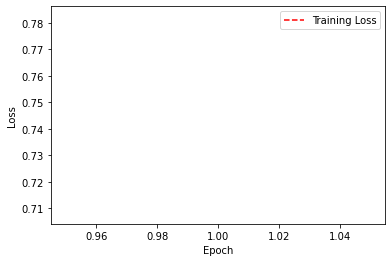

Epoch: 1 Batch: 0 Loss: 0.7637060880661011
Epoch: 1 Batch: 100 Loss: 0.7445234060287476
Epoch: 1 Batch: 200 Loss: 0.7386705279350281
Epoch: 1 Batch: 300 Loss: 0.7456414699554443
Epoch: 1 Batch: 400 Loss: 0.7334964275360107
Epoch: 1 Batch: 500 Loss: 0.7543033361434937
Epoch: 1 Batch: 600 Loss: 0.7623313665390015
Epoch: 1 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, 0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


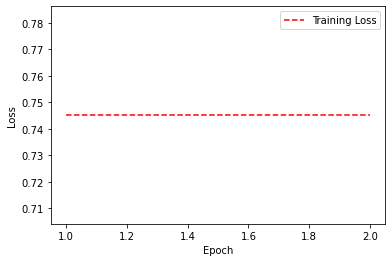

Epoch: 2 Batch: 0 Loss: 0.7637060880661011
Epoch: 2 Batch: 100 Loss: 0.7445234060287476
Epoch: 2 Batch: 200 Loss: 0.7386705279350281
Epoch: 2 Batch: 300 Loss: 0.7456414699554443
Epoch: 2 Batch: 400 Loss: 0.7334964275360107
Epoch: 2 Batch: 500 Loss: 0.7543033361434937
Epoch: 2 Batch: 600 Loss: 0.7623313665390015
Epoch: 2 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, 0.7451705932617188, 0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


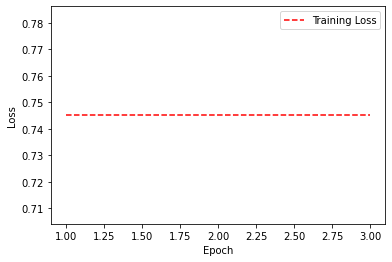

Epoch: 3 Batch: 0 Loss: 0.7637060880661011
Epoch: 3 Batch: 100 Loss: 0.7445234060287476
Epoch: 3 Batch: 200 Loss: 0.7386705279350281
Epoch: 3 Batch: 300 Loss: 0.7456414699554443
Epoch: 3 Batch: 400 Loss: 0.7334964275360107
Epoch: 3 Batch: 500 Loss: 0.7543033361434937
Epoch: 3 Batch: 600 Loss: 0.7623313665390015
Epoch: 3 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


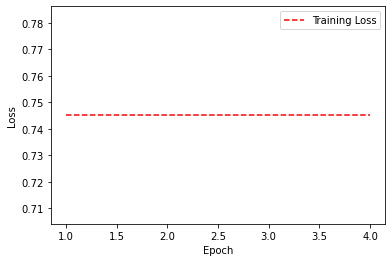

Epoch: 4 Batch: 0 Loss: 0.7637060880661011
Epoch: 4 Batch: 100 Loss: 0.7445234060287476
Epoch: 4 Batch: 200 Loss: 0.7386705279350281
Epoch: 4 Batch: 300 Loss: 0.7456414699554443
Epoch: 4 Batch: 400 Loss: 0.7334964275360107
Epoch: 4 Batch: 500 Loss: 0.7543033361434937
Epoch: 4 Batch: 600 Loss: 0.7623313665390015
Epoch: 4 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


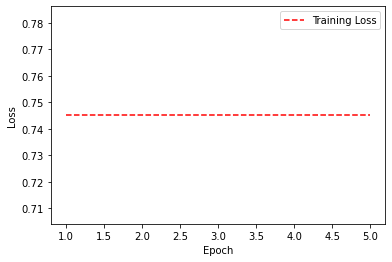

Epoch: 5 Batch: 0 Loss: 0.7637060880661011
Epoch: 5 Batch: 100 Loss: 0.7445234060287476
Epoch: 5 Batch: 200 Loss: 0.7386705279350281
Epoch: 5 Batch: 300 Loss: 0.7456414699554443
Epoch: 5 Batch: 400 Loss: 0.7334964275360107
Epoch: 5 Batch: 500 Loss: 0.7543033361434937
Epoch: 5 Batch: 600 Loss: 0.7623313665390015
Epoch: 5 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


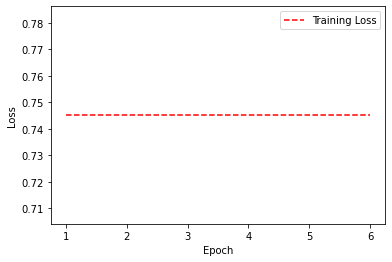

Epoch: 6 Batch: 0 Loss: 0.7637060880661011
Epoch: 6 Batch: 100 Loss: 0.7445234060287476
Epoch: 6 Batch: 200 Loss: 0.7386705279350281
Epoch: 6 Batch: 300 Loss: 0.7456414699554443
Epoch: 6 Batch: 400 Loss: 0.7334964275360107
Epoch: 6 Batch: 500 Loss: 0.7543033361434937
Epoch: 6 Batch: 600 Loss: 0.7623313665390015
Epoch: 6 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


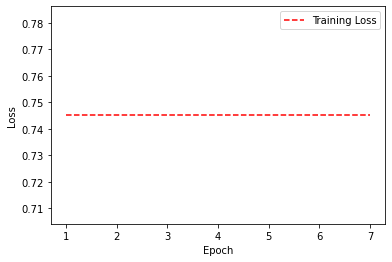

Epoch: 7 Batch: 0 Loss: 0.7637060880661011
Epoch: 7 Batch: 100 Loss: 0.7445234060287476
Epoch: 7 Batch: 200 Loss: 0.7386705279350281
Epoch: 7 Batch: 300 Loss: 0.7456414699554443
Epoch: 7 Batch: 400 Loss: 0.7334964275360107
Epoch: 7 Batch: 500 Loss: 0.7543033361434937
Epoch: 7 Batch: 600 Loss: 0.7623313665390015
Epoch: 7 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


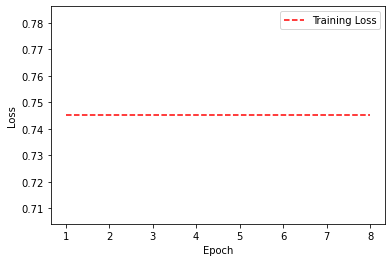

Epoch: 8 Batch: 0 Loss: 0.7637060880661011
Epoch: 8 Batch: 100 Loss: 0.7445234060287476
Epoch: 8 Batch: 200 Loss: 0.7386705279350281
Epoch: 8 Batch: 300 Loss: 0.7456414699554443
Epoch: 8 Batch: 400 Loss: 0.7334964275360107
Epoch: 8 Batch: 500 Loss: 0.7543033361434937
Epoch: 8 Batch: 600 Loss: 0.7623313665390015
Epoch: 8 Loss: 0.7451705932617188
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, 0.7451705932617188, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


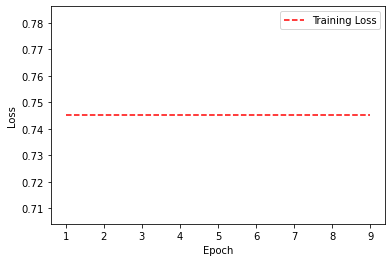

Epoch: 9 Batch: 0 Loss: 0.7637060880661011
Epoch: 9 Batch: 100 Loss: 0.7445234060287476
Epoch: 9 Batch: 200 Loss: 0.7386705279350281
Epoch: 9 Batch: 300 Loss: 0.7456414699554443


KeyboardInterrupt: 

In [17]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor((159571 - 35098) / 35098))
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=64)

print(device)
loss.to(device)
model.to(device)
optimizer = AdamW(glove_model.parameters(), lr=0.001)

epochs = 50000

training_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]

for e in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_id, batch in enumerate(train_dataloader):
        #print('b--------------------------------------------d')
        #print('batch id', batch_id)
        #print('b--------------------------------------------d')
        ids = batch['indices'].to(device)
        # text = torch.tensor(text).to(device)
        labels = batch['label'].to(device)
        #print('labels', labels.device)
        optimizer.zero_grad()
        outputs = model(ids)
        #print('output', outputs.shape)
        #print('labels', labels.shape)

        loss_value = loss(outputs, labels.float())
        loss_value.backward()
        optimizer.step()
        #if batch_id % 100 == 0:
        #    print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss_value.item()))

        epoch_loss = loss_value.item()

    training_losses[e] = (epoch_loss)
    print('Epoch: {} Loss: {}'.format(e, epoch_loss))
    plt.plot(epoch_count, training_losses, 'r--')
    # plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # torch.save(model.state_dict(), './model_save/lstm_{}.pkl'.format(epochs))